# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

C:\Programs\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('/Users/Елена/Documents/webinar_2/retail_train.csv')
item_features = pd.read_csv('/Users/Елена/Documents/webinar_2/product.csv')
user_features = pd.read_csv('/Users/Елена/Documents/webinar_2/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
common_users = data_train_lvl_1.user_id.values

data_val_lvl_1 = data_val_lvl_1 [data_val_lvl_1 .user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

In [5]:
recommender = MainRecommender(data_train_lvl_1)

In [6]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 883932, 5569230, 1022428]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 999270, 1009977, 1133312]

In [9]:
recommender.get_similar_users_recommendation(2375, N=5)

[5574377, 974265, 1012801, 820612, 918638]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [6]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [7]:
def evalRecall(df_result, target_col_name, recommend_model, col_for_result, N=50):
    result_col_name = col_for_result+'_{}'.format(N)
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N)) 
    
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row['actual'], k=N), axis=1).mean()

In [8]:
def calc_recall(df_result, k=50):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=k), axis=1).mean()

In [54]:
def calc_precision(df_result, top_k):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [13]:
k = [20, 50, 100, 200, 500]
recall_at_k_own = []
recall_at_k_als = []
recall_at_k_sim_items = []
for i in k:
   recall_at_k_own.append(evalRecall(result_lvl_1,'user_id', recommender.get_own_recommendations, 'own', N=i))
   recall_at_k_als.append(evalRecall(result_lvl_1,'user_id', recommender.get_als_recommendations, 'als', N=i))
   recall_at_k_sim_items.append(evalRecall(result_lvl_1,'user_id', recommender.get_similar_items_recommendation, 'sim_items', N=i)) 

In [14]:
result_lvl_1.head(2)

,user_id,actual,own_20,als_20,sim_items_20,own_50,als_50,sim_items_50,own_100,als_100,sim_items_100,own_200,als_200,sim_items_200,own_500,als_500,sim_items_500
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1094924, 8090541, 916993, 1064002, 856942, 88...","[824758, 1007512, 894406, 5577022, 912704, 983...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1094924, 8090541, 916993, 1064002, 856942, 88...","[824758, 1007512, 894406, 5577022, 912704, 983...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1094924, 8090541, 916993, 1064002, 856942, 88...","[824758, 1007512, 894406, 5577022, 912704, 983...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1094924, 8090541, 916993, 1064002, 856942, 88...","[824758, 1007512, 894406, 5577022, 912704, 983...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1094924, 8090541, 916993, 1064002, 856942, 88...","[824758, 1007512, 894406, 5577022, 912704, 983..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1042942, 5569845, 1090931, 1102067, ...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1042942, 5569845, 1090931, 1102067, ...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1042942, 5569845, 1090931, 1102067, ...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1042942, 5569845, 1090931, 1102067, ...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1042942, 5569845, 1090931, 1102067, ...","[8090509, 5569845, 1044078, 985999, 880888, 81..."


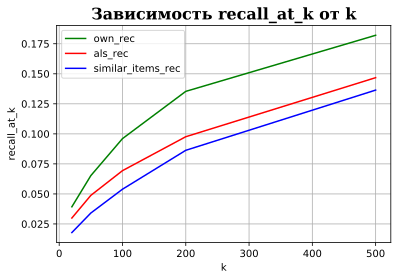

In [15]:
%config InlineBackend.figure_format = 'svg'


plt.title('Зависимость recall_at_k от k', fontsize=16,
    fontweight='bold', family='serif')

plt.plot(k, recall_at_k_own, label='own_rec', color='green')
plt.plot(k, recall_at_k_als, label='als_rec', color='red')
plt.plot(k, recall_at_k_sim_items, label='similar_items_rec', color='blue')

plt.legend()
plt.xlabel('k')
plt.ylabel('recall_at_k')

plt.grid()
plt.show()

In [ ]:
#При большом числе кандидатов будет происходить переобучение модели. Наверное нужно выбрать что-то среднее. Например, 200

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [9]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_lvl_2['user_id'].unique())
df_match_candidates.columns = ['user_id']
df_match_candidates.head()

,user_id
0,2070
1,2021
2,1753
3,2120
4,1346


In [10]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [11]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [12]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [13]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [14]:
df_match_candidates.head(5)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [15]:
df_ranker_train = data_train_lvl_2[['user_id', 'item_id', 'sales_value', 'week_no', 'quantity']].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=['user_id', 'item_id'], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [16]:
df_ranker_train.target.value_counts()

0.0    410478
1.0     27124
Name: target, dtype: int64

In [17]:
df_ranker_train.head()

,user_id,item_id,sales_value,week_no,quantity,target
0,2070,1105426,NaN,NaN,NaN,0.0
1,2070,1097350,NaN,NaN,NaN,0.0
2,2070,879194,NaN,NaN,NaN,0.0
3,2070,948640,NaN,NaN,NaN,0.0
4,2070,928263,NaN,NaN,NaN,0.0


## Подготавливаем фичи для обучения модели

In [18]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [19]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [20]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,sales_value,week_no,quantity,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [21]:
#добавим новую фичу "цена"
df_ranker_train['price'] = df_ranker_train['sales_value'] / (np.maximum(df_ranker_train['quantity'], 1))

In [22]:
#добавим новую фичу "средний чек"
average_check = (df_ranker_train.groupby('user_id')['price'].sum() / df_ranker_train.groupby('user_id')['quantity'].sum()). \
    reset_index(name = 'average_check')

average_check.head()

,user_id,average_check
0,1,2.835000
1,2,2.979167
2,4,9.736000
3,6,2.803077
4,7,3.802500


In [23]:
df_ranker_train = df_ranker_train.merge(average_check, on='user_id', how='left')

In [24]:
df_ranker_train.head()

,user_id,item_id,sales_value,week_no,quantity,target,manufacturer,department,brand,commodity_desc,...,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,price,average_check
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,...,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,...,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875
2,2070,879194,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875
3,2070,948640,NaN,NaN,NaN,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,...,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875
4,2070,928263,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875


In [25]:
# добавим новую фичу "Кол-во покупок в каждой категории"
Quantity_per_cat = df_ranker_train.groupby(['user_id','department'])['quantity'].sum().reset_index(name = 'quantity_per_cat')
df_ranker_train = df_ranker_train.merge(Quantity_per_cat, on=['user_id', 'department'], how='left')

In [26]:
df_ranker_train.head()

,user_id,item_id,sales_value,week_no,quantity,target,manufacturer,department,brand,commodity_desc,...,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,price,average_check,quantity_per_cat
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875,10.0
2,2070,879194,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0
3,2070,948640,NaN,NaN,NaN,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0
4,2070,928263,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0


In [27]:
# добавим новую фичу "Кол-во покупок в неделю"
Quantity_per_week = df_ranker_train.groupby(['item_id','week_no'])['quantity'].sum().reset_index(name = 'quantity_per_week')
df_ranker_train = df_ranker_train.merge(Quantity_per_week, on=['item_id', 'week_no'], how='left')

In [28]:
# добавим новую фичу(Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
Item_cat_average_price = df_ranker_train.groupby('department')['price'].mean().reset_index(name = 'Item_cat_average_price')
df_ranker_train = df_ranker_train.merge(Item_cat_average_price, on='department', how='left')
df_ranker_train['Item_cat_average_price-item_price'] = df_ranker_train['Item_cat_average_price'] - df_ranker_train['price']
df_ranker_train.head()

,user_id,item_id,sales_value,week_no,quantity,target,manufacturer,department,brand,commodity_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,price,average_check,quantity_per_cat,quantity_per_week,Item_cat_average_price,Item_cat_average_price-item_price
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,...,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,3.867101,NaN
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,...,Unknown,Unknown,1,None/Unknown,NaN,3.6875,10.0,NaN,3.197954,NaN
2,2070,879194,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN
3,2070,948640,NaN,NaN,NaN,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,...,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN
4,2070,928263,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,Unknown,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN


In [29]:
#добавим новую фичу
#(Кол-во покупок юзером конкретной категории в неделю) - 
#(Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
ave_item_count_user_cat_week = (df_ranker_train.groupby(['user_id', 'department', 'week_no'])['quantity'].count() - \
df_ranker_train.groupby(['department', 'week_no'])['quantity'].mean()).reset_index(name='ave_item_count_user_cat_week')
ave_item_count_user_cat_week.head()

,department,week_no,user_id,ave_item_count_user_cat_week
0,DELI,86.0,1,-0.044828
1,DELI,86.0,18,1.955172
2,DELI,86.0,68,0.955172
3,DELI,86.0,110,-0.044828
4,DELI,86.0,113,-0.044828


In [30]:
df_ranker_train = df_ranker_train.merge(ave_item_count_user_cat_week, on=['department', 'week_no', 'user_id'], how='left')
df_ranker_train.head()

,user_id,item_id,sales_value,week_no,quantity,target,manufacturer,department,brand,commodity_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,price,average_check,quantity_per_cat,quantity_per_week,Item_cat_average_price,Item_cat_average_price-item_price,ave_item_count_user_cat_week
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,...,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,3.867101,NaN,NaN
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,...,Unknown,1,None/Unknown,NaN,3.6875,10.0,NaN,3.197954,NaN,NaN
2,2070,879194,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN,NaN
3,2070,948640,NaN,NaN,NaN,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,...,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN,NaN
4,2070,928263,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,Unknown,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN,NaN


In [31]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [42]:
cat_feats = ['week_no', 'manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 
             'age_desc', 'marital_status_code','income_desc', 'homeowner_desc', 'hh_comp_desc', 
             'household_size_desc', 'kid_category_desc', 'curr_size_of_product']
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['week_no',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'curr_size_of_product']

## Обучение модели ранжирования

In [43]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Programs\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [47]:
df_ranker_predict = df_ranker_train.copy()

In [48]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [50]:
df_ranker_predict.head()

,user_id,item_id,sales_value,week_no,quantity,target,manufacturer,department,brand,commodity_desc,...,household_size_desc,kid_category_desc,price,average_check,quantity_per_cat,quantity_per_week,Item_cat_average_price,Item_cat_average_price-item_price,ave_item_count_user_cat_week,proba_item_purchase
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,...,1,None/Unknown,NaN,3.6875,0.0,NaN,3.867101,NaN,NaN,1.893025e-08
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,...,1,None/Unknown,NaN,3.6875,10.0,NaN,3.197954,NaN,NaN,1.893025e-08
2,2070,879194,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN,NaN,1.893025e-08
3,2070,948640,NaN,NaN,NaN,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,...,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN,NaN,1.893025e-08
4,2070,928263,NaN,NaN,NaN,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,...,1,None/Unknown,NaN,3.6875,0.0,NaN,5.301682,NaN,NaN,1.893025e-08


# Evaluation on test dataset

In [51]:
result_eval_ranker = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [52]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

Wall time: 16.2 s


In [55]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset

In [56]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [58]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker['user_id'].apply(lambda user_id: rerank(user_id))

In [59]:
print(*sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True), sep='\n')

C:\Users\Елена\Documents\webinar_6\metrics.py:27: RuntimeWarning: invalid value encountered in long_scalars
  precision = flags.sum() / len(recommended_list)


('reranked_own_rec', 0.19321148825065057)
('own_rec', 0.1444117647058813)


In [ ]:
#за счет генерации новых фич, качество на втором уровне стало выше.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 